In [1]:
import pandas as pd
import numpy as np
import scipy
import regression as reg

import netpixi
import graph_tool_extras as gte

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def from_net_to_dataframe(net):
    data = {}
    for v in net.vertices():
        for key, value in v.items():
            key = key.replace(' ', '_')
            if key not in data.keys():
                data[key] = []
            data[key].append(value)
    return pd.DataFrame(data)

In [3]:
g = gte.load('./rede_metricas.net.gz')

In [4]:
data = from_net_to_dataframe(g)
data.head()

,id,aisle,name,purchased_once,purchased_more_than_once,number_of_users_purchased,total_purchases,PRC,_x,_y,closeness,betweenness,degree,clustering
0,13176,fresh fruits,Bag of Organic Bananas,45231,18306,63537,379450,0.288116,-2.771748,4.646514,0.828611,0.188116,0.660171,0.828611
1,47209,fresh fruits,Organic Hass Avocado,29031,14422,43453,213584,0.331899,-2.817030,4.470142,0.730433,0.037636,0.467300,0.730433
2,21137,fresh fruits,Organic Strawberries,38131,20707,58838,264683,0.351932,-2.812644,4.452285,0.756256,0.050082,0.517490,0.756256
3,24852,fresh fruits,Banana,55166,18790,73956,472565,0.254070,-3.111668,4.107787,0.933690,0.517962,0.869106,0.933690
4,47766,fresh fruits,Organic Avocado,27429,15342,42771,176815,0.358701,-2.777847,4.428008,0.702882,0.020128,0.411977,0.702882


In [5]:
independente = data['clustering']
dependente = np.log(data['PRC'])
controle = data['degree']

data_hipotese = pd.DataFrame({
    'dependente': dependente, 
    'independente': independente, 
    'controle': controle
})

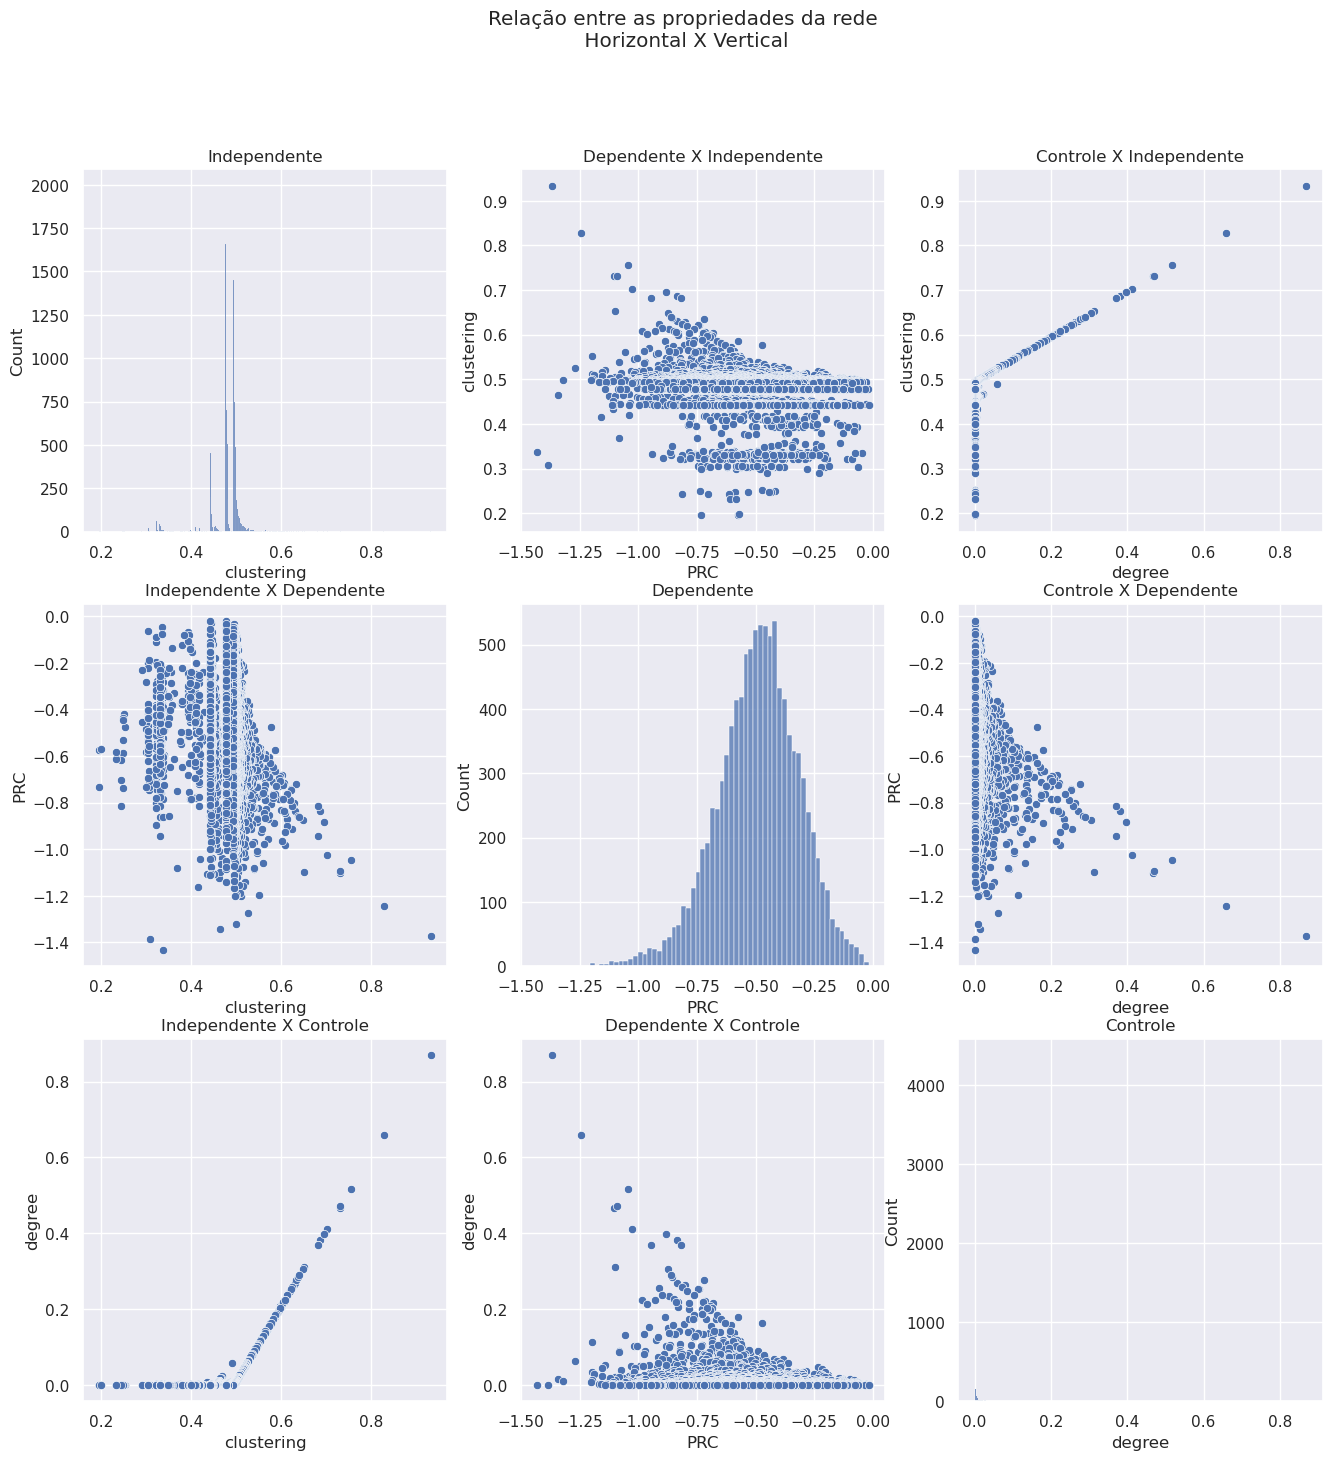

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

fig.suptitle("Relação entre as propriedades da rede\n Horizontal X Vertical")

sns.histplot(independente, ax=axes[0, 0]).set_title("Independente")
sns.scatterplot(x=dependente, y=independente, ax=axes[0, 1]).set_title("Dependente X Independente")
sns.scatterplot(x=controle, y=independente, ax=axes[0, 2]).set_title("Controle X Independente")

sns.scatterplot(x=independente, y=dependente, ax=axes[1, 0]).set_title("Independente X Dependente")
sns.histplot(dependente, ax=axes[1, 1]).set_title("Dependente")
sns.scatterplot(x=controle, y=dependente, ax=axes[1, 2]).set_title("Controle X Dependente")

sns.scatterplot(x=independente, y=controle, ax=axes[2, 0]).set_title("Independente X Controle")
sns.scatterplot(x=dependente, y=controle, ax=axes[2, 1]).set_title("Dependente X Controle")
sns.histplot(controle, ax=axes[2, 2]).set_title("Controle")

plt.show()

In [7]:
def pearsonr(x, y, ndigits=10):
    statistic, p_value = scipy.stats.pearsonr(x, y)
    
    asterisk = ''
    statistic = round(statistic, ndigits)
    
    if statistic == 1: 
        asterisk = ' (óbvio)'
    elif p_value < 0.01: 
        asterisk = ' ***'
    elif p_value < 0.05: 
        asterisk = ' **'
    elif p_value < 0.1: 
        asterisk = ' *'
        
    return f'{statistic} {asterisk}'

In [25]:
columns = ['independente', 'dependente', 'controle']
[pd.Series([pearsonr(data_hipotese[j], data_hipotese[i]) for j in columns], name=i) for i in columns]

[0          1.0  (óbvio)
 1    -0.1296074453  ***
 2     0.4550250368  ***
 Name: independente, dtype: object,
 0    -0.1296074453  ***
 1          1.0  (óbvio)
 2    -0.2593728683  ***
 Name: dependente, dtype: object,
 0     0.4550250368  ***
 1    -0.2593728683  ***
 2          1.0  (óbvio)
 Name: controle, dtype: object]

In [9]:
result = reg.linear(data=data_hipotese, formula='dependente ~ independente + controle') # dependente à esquerda!
result.micro_summary()

variable,coefficient,std error,p-value
independente,-0.069809,0.050520,0.167058
controle,-1.744347,0.072985,0.000000


In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dependente   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     380.3
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          3.32e-160
Time:                        22:23:27   Log-Likelihood:                 3675.4
No. Observations:               10521   AIC:                            -7345.
Df Residuals:                   10518   BIC:                            -7323.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.4452      0.024    -18.406      0.000      -0.493      -0.398
independente    -0.0698      0.051     -1.382      0.167      -0.169       0.029
controle        -1.7443      0.073    -23.900      0.000      -1.887      -1.601
==============================================================================
Omnibus:                      376.450   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              496.314
Skew:                          -0.389   Prob(JB):                    1.69e-108
Kurtosis:                       3.726   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

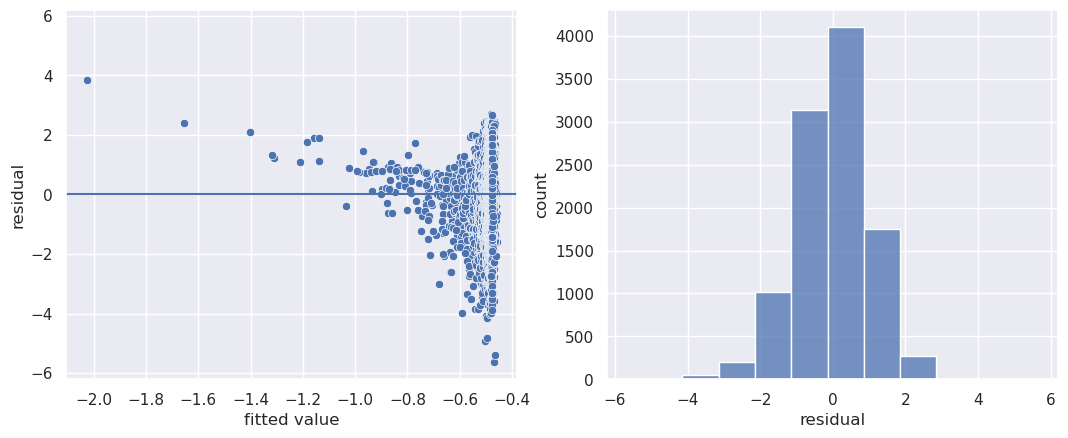

In [11]:
result.plot_residuals()

In [12]:
# import os
# if not os.path.isdir('img'):
#     os.mkdir('img')

# sns.histplot(PPC).get_figure().savefig('./img/hist_independente.png')
# plt.close()
# sns.scatterplot(x=PRC, y=PPC).get_figure().savefig('./img/dependente_independente.png')
# plt.close()
# sns.scatterplot(x=N_USERS, y=PPC).get_figure().savefig('./img/controle_independente.png')
# plt.close()

# sns.scatterplot(x=PPC, y=PRC).get_figure().savefig('./img/independente_dependente.png')
# plt.close()
# sns.histplot(PRC).get_figure().savefig('./img/hist_dependente.png')
# plt.close()
# sns.scatterplot(x=N_USERS, y=PRC).get_figure().savefig('./img/controle_dependente.png')
# plt.close()

# sns.scatterplot(x=PPC, y=N_USERS).get_figure().savefig('./img/independente_controle.png')
# plt.close()
# sns.scatterplot(x=PRC, y=N_USERS).get_figure().savefig('./img/dependente_controle.png')
# plt.close()
# sns.histplot(N_USERS).get_figure().savefig('./img/hist_controle.png')
# plt.close()